# simulated pump probe for testing ridge, constrained, or more advanced regression

In [1]:
import numpy as np
from matplotlib import pyplot as plt
from scipy.stats import binned_statistic_dd
from scipy.optimize import least_squares
from scipy.optimize import leastsq
import sympy
import symfit


In [3]:
symfit.__version__

'0.4.6'

In [24]:
sympy.__version__

'1.4'

## making simulated data

In [4]:
def y(t,a,w,phi,tau):
    return 50+np.heaviside(t,0)*(-5*np.exp(-t/tau)+a*np.exp(-t/tau)*np.sin(w*t+phi))
    


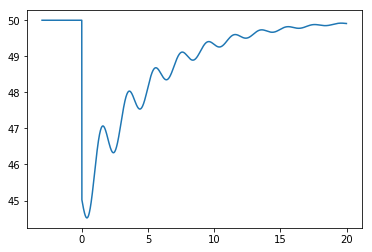

In [5]:
t = np.arange(-3,20,0.01)
plt.plot(t,y(t,1,np.pi,3.1,5))

In [6]:
t_sim     =  np.random.rand(4*len(t))*23-3
e_sim     =  np.random.normal(916,3,len(t_sim))
e_noisy   =  e_sim + np.random.normal(0,1,len(t_sim))
y_sim     =  y(t_sim,1,np.pi,3.1,5) #+np.random.normal(0,1,len(t_sim))
IFEE_sim  =  np.random.rand(len(t_sim))
I0_sim    =  IFEE_sim*np.exp(-(913-e_noisy)**2/4**2)+np.random.normal(0.0,0.2,len(t_sim))**2
I_sim     =  I0_sim*y_sim *10* (1+(e_sim-895)/50.0) +np.random.normal(0,0.8,len(t_sim))**2

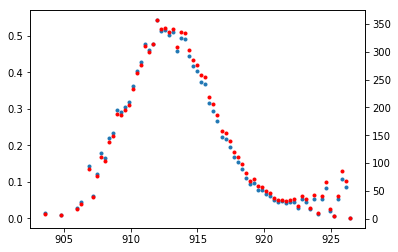

In [7]:
my_bins = np.arange(900,930,0.3)

my_binned_stat = binned_statistic_dd(e_sim,I0_sim,bins=[my_bins],statistic=np.average)
plt.plot(my_binned_stat.bin_edges[0][:-1],my_binned_stat.statistic,'.',alpha=1)
plt.twinx()
my_binned_stat = binned_statistic_dd(e_sim,I_sim,bins=[my_bins],statistic=np.average)
plt.plot(my_binned_stat.bin_edges[0][:-1],my_binned_stat.statistic,'.',alpha=1,color='r')

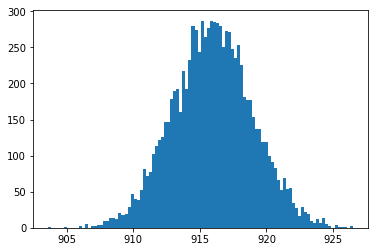

In [8]:
dummy_hist = plt.hist(e_sim,bins=100)

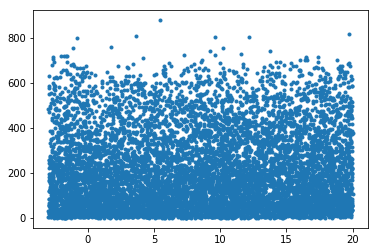

In [9]:
plt.plot(t_sim,I_sim,'.')
plt.show()

## global using symfit

In [10]:
xdata = np.arange(8,21,0.2)
ydata = 3.1* np.e**(-(xdata - 15)**2/(2 * 2**2))
ydata += np.random.rand(len(ydata))

In [16]:
print(xdata)
print(ydata)

[ 8.   8.2  8.4  8.6  8.8  9.   9.2  9.4  9.6  9.8 10.  10.2 10.4 10.6
 10.8 11.  11.2 11.4 11.6 11.8 12.  12.2 12.4 12.6 12.8 13.  13.2 13.4
 13.6 13.8 14.  14.2 14.4 14.6 14.8 15.  15.2 15.4 15.6 15.8 16.  16.2
 16.4 16.6 16.8 17.  17.2 17.4 17.6 17.8 18.  18.2 18.4 18.6 18.8 19.
 19.2 19.4 19.6 19.8 20.  20.2 20.4 20.6 20.8]
[0.73492428 0.61485196 0.62464574 0.08199097 0.32822424 0.78803386
 0.51647046 0.09977165 0.46164898 0.60485159 1.12785207 0.24463427
 0.84881556 0.73466175 0.82249698 1.36003305 1.10133672 0.76223945
 0.93794119 1.21380533 1.2941648  1.75767294 1.55499619 2.07164385
 1.78323282 2.33162085 2.09427533 2.84385209 3.09361311 2.89862244
 2.88736208 3.74415488 3.33073457 3.44914061 3.11567567 3.68774554
 3.60769161 3.68583188 3.78624555 2.87285495 3.68428874 2.82134709
 3.28966983 2.92169283 2.79846997 2.8376836  2.51000321 2.14840655
 1.90445172 1.99535338 1.50089192 0.92579714 1.22930152 1.01797555
 1.4369907  0.5634132  0.67610039 0.73610526 0.28142801 0.54162917


In [20]:
x = symfit.Variable()
A = symfit.Parameter('A',3)
sig = symfit.Parameter('sig',2.3, min=0.2, max=5.0)
x0 = symfit.Parameter('x0',16, min=0.0)

# Gaussian distrubution
model = A * symfit.exp(-(x0 - 15)**2/(2 * sig**2))

/reg/g/psdm/sw/conda/inst/miniconda2-prod-rhel7/envs/deeplearning/lib/python3.6/site-packages/ipykernel/__main__.py:1: DeprecationWarning: It is recommended to provide names to Variable explicitly as automatic generation of names will be dropped in future `symfit` versions.
  if __name__ == '__main__':


In [21]:
fit = symfit.Fit(model, xdata, ydata)
fit_result = fit.execute()

In [22]:
fit_result.params

OrderedDict([('A', 18.001484088418596),
             ('sig', 5.0),
             ('x0', 9.777786834030573)])

In [136]:
y = model(x=xdata, **fit_result.params)

In [23]:
model(x=xdata, **fit_result.params)

10.433523096103203

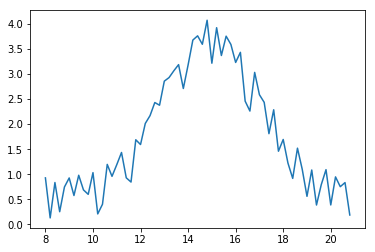

In [116]:
plt.plot(xdata,ydata)
#plt.plot(y,xdata)
plt.show()

In [44]:
t_bins = np.arange(-3,20,0.05)

In [77]:
energy  = symfit.Variable('energy')
I0      = symfit.Variable('I0')
offset  = symfit.Parameter('offset',0)
IvsI0_E = symfit.Parameter('IvsI0_E',0)
IvsI0   = [symfit.Parameter('bin'+str(i),45) for i in range(len(t_bins))]

In [78]:
#I_sim = I0_sim*y_sim *10* (1+(e_sim-895)/50.0) +np.random.normal(0,0.8,len(t_sim))**2
model   = IvsI0[0]*I0*(1+IvsI0_E*energy) +offset

In [86]:
fit = symfit.Fit(model,np.array([t_sim,I0_sim]),I_sim)

In [87]:
fit_result = fit.execute()

AttributeError: 'Variable' object has no attribute 'symbol'

## standard bin by bin regression

In [22]:
t_bins = np.arange(-3,20,0.05)

my_pump_probe = []

residuals = []

I_sim_size = 0

for i in np.arange(len(t_bins)-1):
    my_mask  = (t_sim >= t_bins[i])
    my_mask *= (t_sim <= t_bins[i+1])
    
    X = np.array([np.ones(np.sum(my_mask)),I0_sim[my_mask]-np.mean(I0_sim[my_mask]),(e_sim[my_mask]-np.mean(e_sim[my_mask])),(I0_sim[my_mask]-np.mean(I0_sim[my_mask]))*(e_sim[my_mask]-np.mean(e_sim[my_mask])) ])
    #X = np.array([np.ones(np.sum(my_mask)),I0_sim[my_mask],(I0_sim[my_mask])*(e_sim[my_mask]-np.mean(e_sim[my_mask])) ])
    beta = np.dot(np.linalg.pinv(X.transpose()),I_sim[my_mask])
    
    residuals.append(list((I_sim[my_mask]-np.dot(X.transpose(),np.array([beta]).transpose())[:,0])))
    I_sim_size = I_sim_size+I_sim[my_mask].shape[0]
    my_pump_probe.append(beta)

In [23]:
my_pump_probe = np.array(my_pump_probe)

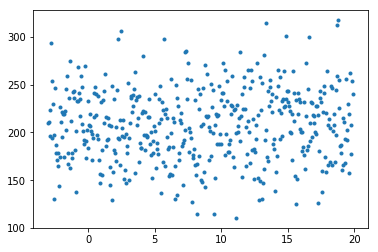

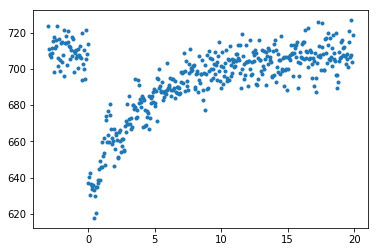

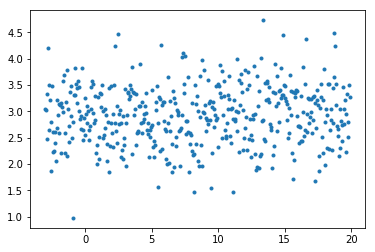

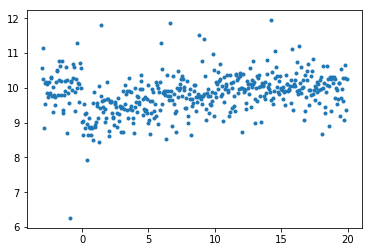

In [24]:
for i in range(X.shape[0]):
    plt.plot(t_bins[:-1],my_pump_probe[:,i],'.')
    plt.show()

## ridge regression

### making big matrix for linearized system


In [25]:
#make giant matrix
t_bins = np.arange(-3,20,0.05)

my_pump_probe = []

big_X = np.zeros([I_sim.shape[0],t_bins.shape[0]*4])
big_Y = np.zeros([I_sim.shape[0],t_bins.shape[0]])

my_col = 0
my_row = 0

my_ycol = 0
my_yrow = 0

for i in np.arange(len(t_bins)-1):
    my_mask  = (t_sim >= t_bins[i])
    my_mask *= (t_sim <= t_bins[i+1])
    
    X = (np.array([np.ones(np.sum(my_mask)),I0_sim[my_mask],(e_sim[my_mask]-np.mean(e_sim[my_mask])),(I0_sim[my_mask]-np.mean(I0_sim[my_mask]))*(e_sim[my_mask]-np.mean(e_sim[my_mask])) ])).transpose()
    Y = I_sim[my_mask]
    
    big_X[my_row:my_row+X.shape[0],my_col:my_col + X.shape[1]] = X
    big_Y[my_yrow:my_yrow+Y.shape[0],my_ycol] = Y
    
    my_col = my_col + X.shape[1]
    my_row = my_row + X.shape[0]
    
    my_ycol = my_ycol + 1
    my_yrow = my_yrow + Y.shape[0]

    
    #beta = np.dot(np.linalg.pinv(X.transpose()),I_sim[my_mask])
    #my_pump_probe.append(beta)

In [26]:
pseudo_inv = np.linalg.pinv(big_X)

## diagonal beta

In [27]:
beta = np.dot(pseudo_inv,big_Y)

In [28]:
beta.shape

(1840, 460)

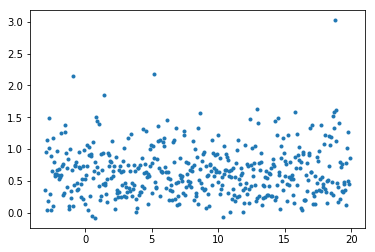

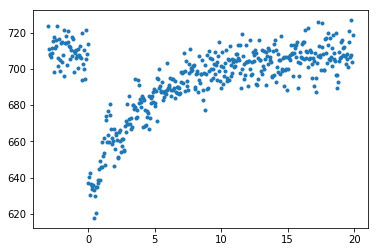

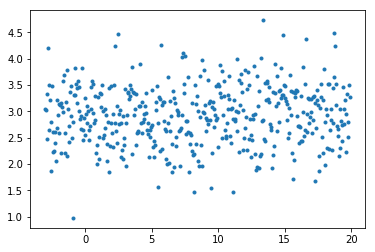

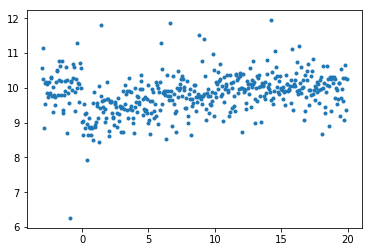

In [29]:
for i in range(4):
    plt.plot(t_bins[:-1],np.diag(beta[i::X.shape[1]][:-1]),'.')
    plt.show()

In [30]:
#now need to implement the tikhonov matrix to constrain standard dev of beta parameters that aren't pump probe
#related and use cross validation to tune them.

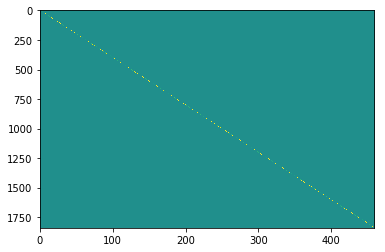

In [31]:
plt.imshow(beta,aspect='auto',clim=(-10,10))

In [32]:
#make ridge kernel
print(beta.shape)
print(big_Y.shape)
print(big_X.shape)

(1840, 460)
(9200, 460)
(9200, 1840)


In [33]:
gamma = 1*(+)

regularization_term = np.dot(np.linalg.inv(np.dot(gamma.transpose(),gamma)),big_X.transpose())


beta = np.dot(pseudo_inv,big_Y) + 

SyntaxError: invalid syntax (<ipython-input-33-01af5d75b94e>, line 1)